[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# The Extended Kalman Filter

In [1]:
#format the book
%matplotlib inline
from __future__ import division, print_function
import book_format
book_format.load_style()

**Author's note: this is still being heavily edited and added to - there is a lot of duplicate material, incorrect code, and so on. The examples are just a brain dump, not fully formulated and not ready to be used.**

**The Unscented Kalman filter (UKF) chapter is much further along. The UKF is almost always better performing than the Extended Kalman filter, and is much easier to implement, so if you have an urgent need for nonlinear Kalman filter I'll point you towards that chapter for now.**

The Kalman filter that we have developed to this point is extremely good, but it is also limited. Its derivation is in the linear space, and hence it only works for linear problems. Let's be a bit more rigorous here. You can, and we have in this book, apply the Kalman filter to nonlinear problems. For example, in the g-h filter chapter we explored using a g-h filter in a problem with constant acceleration. It 'worked', in that it remained numerically stable and the filtered output did track the input, but there was always a lag. It is easy to prove that there will always be a lag when $\mathbf{\ddot{x}}>0$. The filter no longer produces an optimal result. If we make our time step arbitrarily small we can still handle many problems, but typically we are using Kalman filters with physical sensors and solving real-time problems. Either fast enough sensors do not exist, are prohibitively expensive, or the computation time required is excessive. It is not a workable solution.

The early adopters of Kalman filters were the radar people, and this fact was not lost on them. Radar is inherently nonlinear. Radars measure the slant range to an object, and we are typically interested in the aircraft's position over the ground. We invoke Pythagoras and get the nonlinear equation:
$$x=\sqrt{slant^2 - altitude^2}$$

So shortly after the Kalman filter was enthusiastically taken up by the radar industry people began working on how to extend the Kalman filter into nonlinear problems. It is still an area of ongoing research, and in the Unscented Kalman filter chapter we will implement a powerful, recent result of that research. But in this chapter we will cover the most common form, the Extended Kalman filter, or EKF. Today, most real world "Kalman filters" are actually EKFs. The Kalman filter in your car's and phone's GPS is almost certainly an EKF, for example. 

With that said, there are new techniques that have been developed that both perform equal to or better than the EKF, and require much less math. The next chapter 

## The Problem with Nonlinearity

You may not realize it, but the only math you really know how to do is linear math. Equations of the form 
$$ A\mathbf{x}=\mathbf{b}$$.

That may strike you as hyperbole. After all, in this book we have integrated a polynomial to get distance from velocity and time:
 We know how to integrate a polynomial, for example, and so we are able to find the closed form equation for distance given velocity and time:
$$\int{(vt+v_0)}\,dt = \frac{a}{2}t^2+v_0t+d_0$$

That's nonlinear. But it is also a very special form. You spent a lot of time, probably at least a year, learning how to integrate various terms, and you still can not integrate some arbitrary equation - no one can. We don't know how. If you took freshman Physics you perhaps remember homework involving sliding frictionless blocks on a plane and other toy problems. At the end of the course you were almost entirely unequipped to solve real world problems because the real world is nonlinear, and you were taught linear, closed forms of equations. It made the math tractable, but mostly useless. 

The mathematics of the Kalman filter is beautiful in part due to the Gaussian equation being so special. It is nonlinear, but when we add and multiply it using linear algebra we get another Gaussian equation as a result. That is very rare. $\sin{x}*\sin{y}$ does not yield a $\sin(\cdot)$ as an output.

> If you are not well versed in signals and systems there is a perhaps startling fact that you should be aware of. A linear system is defined as a system whose output is linearly proportional to the sum of all its inputs. A consequence of this is that to be linear if the input is zero than the output must also be zero. Consider an audio amp - if a sing into a microphone, and you start talking, the output should be the sum of our voices (input) scaled by the amplifier gain. But if amplifier outputs a nonzero signal for a zero input the additive relationship no longer holds. This is because you can say $amp(roger) = amp(roger + 0)$ This clearly should give the same output, but if amp(0) is nonzero, then

> $$
\begin{aligned}
amp(roger) &= amp(roger + 0) \\
&= amp(roger) + amp(0) \\
&= amp(roger) + non\_zero\_value
\end{aligned}
$$

>which is clearly nonsense. Hence, an apparently linear equation such as
$$L(f(t)) = f(t) + 1$$

>is not linear because $L(0) = 1$! Be careful!

## The Effect of Nonlinear Transfer Functions on Gaussians

Unfortunately Gaussians are not closed under an arbitrary nonlinear function. Recall the equations of the Kalman filter - at each step of its evolution we do things like pass the covariances through our process function to get the new covariance at time $k$. Our process function was always linear, so the output was always another Gaussian.  Let's look at that on a graph. I will take an arbitrary Gaussian and pass it through the function $f(x) = 2x + 1$ and plot the result. We know how to do this analytically, but lets do this with sampling. I will generate 500,000 points on the Gaussian curve, pass it through the function, and then plot the results. I will do it this way because the next example will be nonlinear, and we will have no way to compute this analytically.

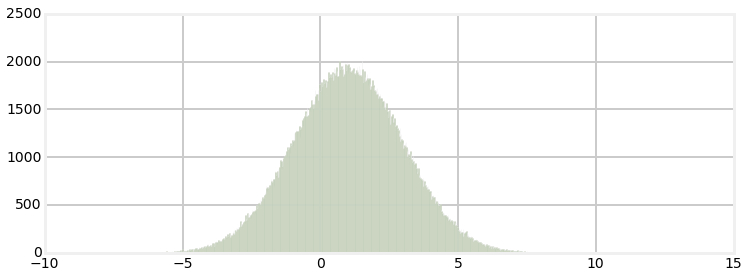

In [2]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt

data = normal(loc=0.0, scale=1, size=500000)
ys = 2*data + 1

plt.hist(ys, 1000)
plt.show()

This is an unsurprising result. The result of passing the Gaussian through $f(x)=2x+1$ is another Gaussian centered around 1. Let's look at the input, transfer function, and output at once.

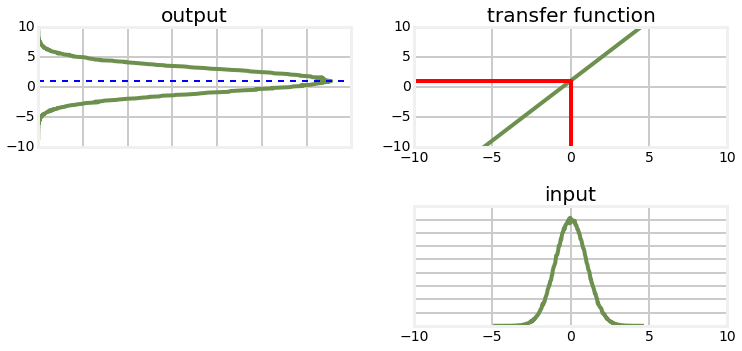

In [3]:
from nonlinear_plots import plot_transfer_func

def g(x):
    return 2*x + 1

with book_format.figsize(y=5):
    plot_transfer_func(data, g, lims=(-10, 10), num_bins=300)

The plot labeled 'input' is the histogram of the original data. This is passed through the transfer function $f(x)=2x+1$ which is displayed in the chart to the upper right. The red lines shows how one value, $x=0$ is passed through the function. Each value from input is passed through in the same way to the output function on the left. The output looks like a Gaussian, and is in fact a Gaussian. We can see that it is altered -the variance in the output is larger than the variance in the input, and the mean has been shifted from 0 to 1, which is what we would expect given the transfer function $f(x)=2x+1$ The $2x$ affects the variance, and the $+1$ shifts the mean.

Now let's look at a nonlinear function and see how it affects the probability distribution.

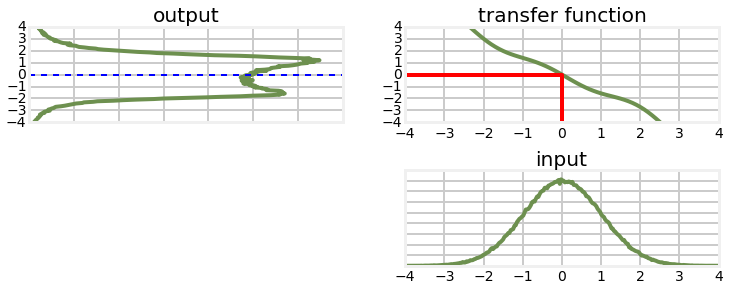

In [4]:
from nonlinear_plots import plot_transfer_func

def g(x):
    return (np.cos(4*(x/2 + 0.7)))*np.sin(0.3*x) - 1.6*x

plot_transfer_func(data, g, lims=(-4, 4), num_bins=300)

This result may be somewhat surprising to you. The transfer function looks "fairly" linear - it is pretty close to a straight line, but the probability distribution of the output is completely different from a Gaussian.  Recall the equations for multiplying two univariate Gaussians:
$$\begin{aligned}
\mu =\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}\mbox{, } 
\sigma = \frac{1}{\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}}
\end{aligned}$$

These equations do not hold for non-Gaussians, and certainly do not hold for the probability distribution shown in the 'output' chart above. 

Think of what this implies for the Kalman filter algorithm of the previous chapter. All of the equations assume that a Gaussian passed through the process function results in another Gaussian. If this is not true then all of the assumptions and guarantees of the Kalman filter do not hold. Let's look at what happens when we pass the output back through the function again, simulating the next step time step of the Kalman filter.

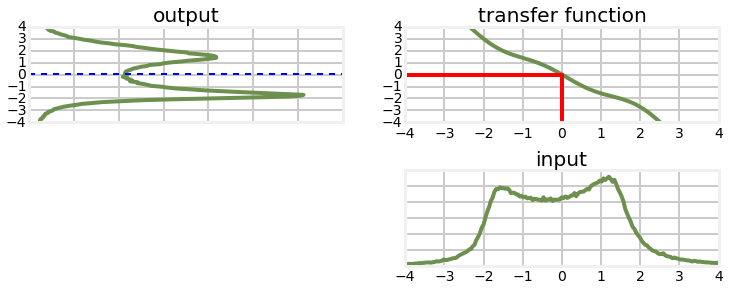

In [5]:
y = g(data)
plot_transfer_func(y, g, lims=(-4, 4), num_bins=300)

As you can see the probability function is further distorted from the original Gaussian. However, the graph is still somewhat symmetric around $0$, let's see what the mean is.

In [6]:
print('input  mean, variance: %.4f, %.4f'% (np.average(data), np.std(data)**2))
print('output mean, variance: %.4f, %.4f'% (np.average(y), np.std(y)**2))

input  mean, variance: 0.0006, 0.9957
output mean, variance: -0.0284, 2.2332


Let's compare that to the linear function that passes through (-2,3) and (2,-3), which is very close to the nonlinear function we have plotted. Using the equation of a line we have
$$m=\frac{-3-3}{2-(-2)}=-1.5$$

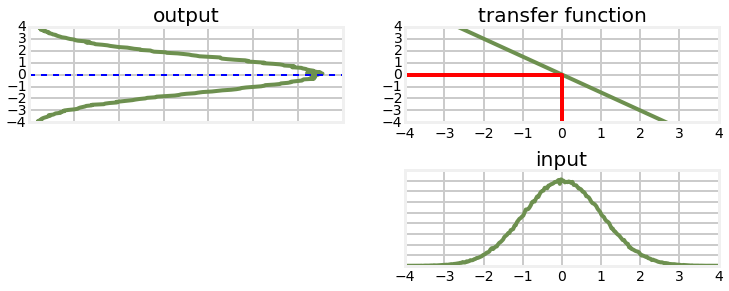

output mean, variance: -0.0009, 2.2404


In [7]:
def h(x):
    return -1.5 * x
plot_transfer_func(data, h, lims=(-4, 4), num_bins=300)
out = h(data)
print ('output mean, variance: %.4f, %.4f' % (np.average(out), np.std(out)**2))

Although the shapes of the output are very different, the mean and variance of each are almost the same. This may lead us to reasoning that perhaps we can ignore this problem if the nonlinear equation is 'close to' linear. To test that, we can iterate several times and then compare the results.

In [8]:
out = h(data)
out2 = g(data)

for i in range(10):
    out = h(out)
    out2 = g(out2)
print('linear    output mean, variance: %.4f, %.4f' % 
      (np.average(out), np.std(out)**2))
print('nonlinear output mean, variance: %.4f, %.4f' % 
      (np.average(out2), np.std(out2)**2))

linear    output mean, variance: -0.0533, 7449.9848
nonlinear output mean, variance: -1.9719, 26065.4836


Unfortunately we can see that the nonlinear version is not stable. We have drifted significantly from the mean of 0, and the variance is half an order of magnitude larger. 

## The Extended Kalman Filter

The extended Kalman filter (EKF) works by linearizing the system model at each update. For example, consider the problem of tracking a cannonball in flight. Obviously it follows a curved flight path. However, if our update rate is small enough, say 1/10 second, then the trajectory over that time is nearly linear. If we linearize that short segment we will get an answer very close to the actual value, and we can use that value to perform the prediction step of the filter. There are many ways to linearize a set of nonlinear differential equations, and the topic is somewhat beyond the scope of this book. In practice, a Taylor series approximation is frequently used with EKFs, and that is what we will use. 


Consider the function $f(x)=x^2−2x$, which we have plotted below.

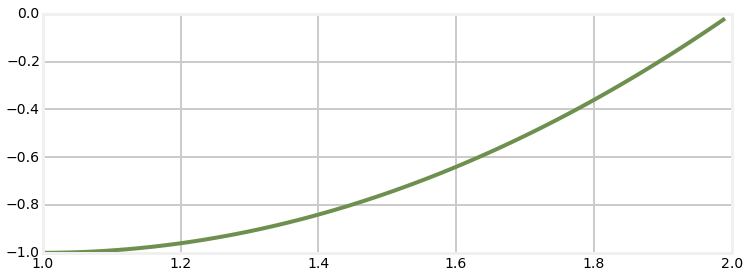

In [9]:
xs =  np.arange(0, 2, 0.01)
ys = [x**2 - 2*x for x in xs]
plt.plot (xs, ys)
plt.xlim(1, 2)
plt.show()

We want a linear approximation of this function so that we can use it in the Kalman filter. We will see how it is used in the Kalman filter in the next section, so don't worry about that yet. We can see that there is no single linear function (line) that gives a close approximation of this function. However, during each innovation (update) of the Kalman filter we know its current state, so if we linearize the function at that value we will have a close approximation. For example, suppose our current state is $x=1.5$. What would be a good linearization for this function?

We can use any linear function that passes through the curve at (1.5,-0.75). For example, consider using f(x)=8x−12.75 as the linearization, as in the plot below.

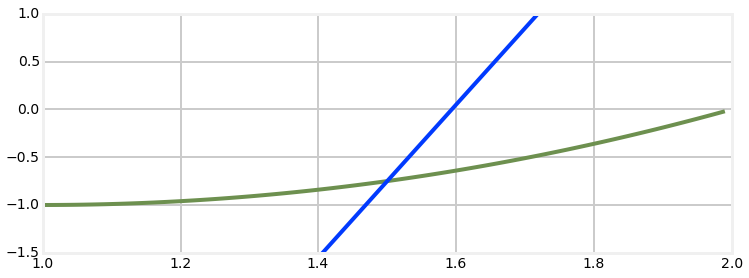

In [10]:
def y(x): 
    return 8*x - 12.75
plt.plot (xs, ys)
plt.plot ([1.25, 1.75], [y(1.25), y(1.75)])
plt.xlim(1, 2)
plt.ylim([-1.5, 1])
plt.show()

This is not a good linearization for $f(x)$. It is exact for $x=1.5$, but quickly diverges when $x$ varies by a small amount.

A much better approach is to use the slope of the function at the evaluation point as the linearization. We find the slope by taking the first derivative of the function:

 $$f(x) = x^2 -2x \\
 \frac{df}{dx} = 2x - 2$$, 
 
 so the slope at 1.5 is $2*1.5-2=1$. Let's plot that.

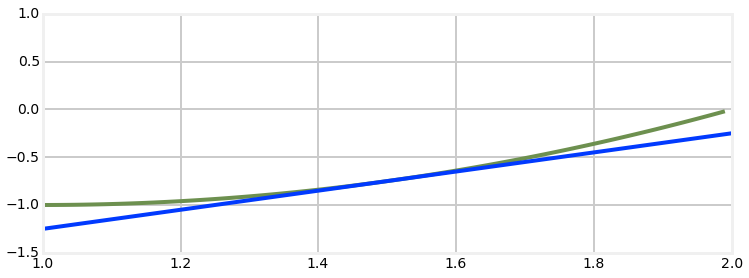

In [11]:
def y(x): 
    return x - 2.25

plt.plot(xs, ys)
plt.plot([1, 2], [y(1), y(2)])
plt.xlim(1, 2)
plt.ylim([-1.5, 1])
plt.show()

Here we can see that this linearization is much better. It is still exactly correct at $x=1.5$, but the errors are very small as x varies. Compare the tiny error at $x=1.4$ vs the very large error at $x=1.4$ in the previous plot. This does not constitute a formal proof of correctness, but this sort of geometric depiction should be fairly convincing. Certainly it is easy to see that in this case if the line had any other slope the errors would accumulate more quickly. 

To implement the extended Kalman filter we will leave the linear equations as they are, and use partial derivatives to evaluate the system matrix $\mathbf{F}$ and the measurement matrix $\mathbf{H}$ at the state at time t ($\mathbf{x}_t$). Since $\mathbf{F}$ also depends on the control input vector $\mathbf{u}$ we will need to include that term:

$$
\begin{aligned}
F 
&\equiv {\frac{\partial{f}}{\partial{x}}}\biggr|_{{x_t},{u_t}} \\
H &\equiv \frac{\partial{h}}{\partial{x}}\biggr|_{x_t} 
\end{aligned}
$$

All this means is that at each update step we compute $\mathbf{F}$ as the partial derivative of our function $f()$ evaluated at  x. 

We approximate the state transition function $\mathbf{F}$ by using the Taylor-series expansion 


** orphan text
This approach has many issues. First, of course, is the fact that the linearization does not produce an exact answer. More importantly, we are not linearizing the actual path, but our filter's estimation of the path. We linearize the estimation because it is statistically likely to be correct; but of course it is not required to be. So if the filter's output is bad that will cause us to linearize an incorrect estimate, which will almost certainly lead to an even worse estimate. In these cases the filter will quickly diverge. This is where the 'black art' of Kalman filter comes in. We are trying to linearize an estimate, and there is no guarantee that the filter will be stable. A vast amount of the literature on Kalman filters is devoted to this problem. Another issue is that we need to linearize the system using analytic methods. It may be difficult or impossible to find an analytic solution to some problems. In other cases we may be able to find the linearization, but the computation is very expensive. **

In the next chapter we will spend a lot of time on a new development, the unscented Kalman filter(UKF) which avoids many of these problems. I think that as it becomes better known it will supplant the EKF in most applications, though that is still an open question. Certainly research has shown that the UKF performs at least as well as, and often much better than the EKF. 

I think the easiest way to understand the EKF is to just start off with an example. Perhaps the reason for some of my mathematical choices will not be clear, but trust that the end result will be an EKF.

## Example: Tracking a Flying Airplane

We will start by simulating tracking an airplane by using ground based radar. Radars work by emitting a beam of radio waves and scanning for a return bounce. Anything in the beam's path will reflects some of the signal back to the radar. By timing how long it takes for the reflected signal to get back to the radar the system can compute the *slant distance* - the straight line distance from the radar installation to the object.

For this example we want to take the slant range measurement from the radar and compute the horizontal position (distance of aircraft from the radar measured over the ground) and altitude of the aircraft, as in the diagram below.

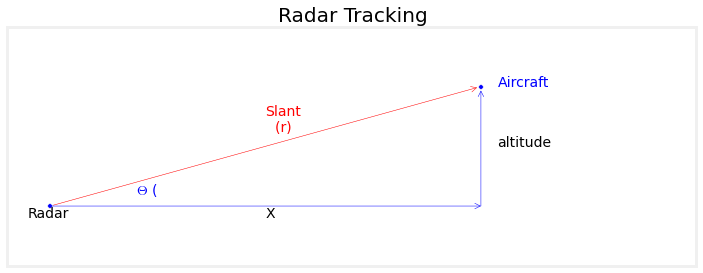

In [12]:
import ekf_internal
ekf_internal.show_radar_chart()

As discussed in the introduction, our measurement model is the nonlinear function $x=\sqrt{slant^2 - altitude^2}$. Therefore we will need a nonlinear 

Predict step:
$$
\begin{array}{ll}
\textbf{Linear} & \textbf{Nonlinear} \\
x = Fx & x = \underline{f(x)} \\
P = FPF^T + Q & P = FPF^T + Q
\end{array}
$$

Update step:
$$
\begin{array}{ll}
\textbf{Linear} & \textbf{Nonlinear} \\
K = PH^T(HPH^T + R)^{-1}& K = PH^T(HPH^T + R)^{-1}\\
x = x + K(z-Hx) & x = x + K(z-\underline{h(x)}) \\
P = P(I - KH) & P = P(I - KH)\\
\end{array}
$$



As we can see there are two minor changes to the Kalman filter equations, which I have underlined. The first change replaces the equation $\mathbf{x} = \mathbf{Fx}$ with $\mathbf{x} = f(\mathbf{x})$. In the Kalman filter, $\mathbf{Fx}$ is how we compute the new state based on the old state. However, in a nonlinear system we cannot use linear algebra to compute this transition. So instead we hypothesize a nonlinear function $f()$ which performs this function. Likewise, in the Kalman filter we convert the state to a measurement with the linear function $\mathbf{Hx}$. For the extended Kalman filter we replace this with a nonlinear function $h()$, giving $\mathbf{z}_x = h(\mathbf{x})$.

The only question left is how do we implement use $f()$ and $h()$ in the Kalman filter if they are nonlinear? We reach for the single tool that we have available for solving nonlinear equations - we linearize them at the point we want to evaluate the system.  For example, consider the function $f(x) = x^2 -2x$


The rest of the equations are unchanged, so $f()$ and $h()$ must produce a matrix that approximates the values of the matrices $\mathbf{F}$ and $\mathbf{H}$ at the current value for $\mathbf{x}$. We do this by computing the partial derivatives of the state and measurements functions:

### Design the State Variables

So we want to track the position of an aircraft assuming a constant velocity and altitude, and measurements of the slant distance to the aircraft. That means we need 3 state variables - horizontal distance, velocity, and altitude.

$$\mathbf{x} = \begin{bmatrix}distance \\velocity\\ altitude\end{bmatrix}=  \begin{bmatrix}x_{pos} \\x_{vel}\\ x_{alt}\end{bmatrix}$$

### Design the System Model

We will model this as a set of differential equations. So we need an equation in the form 
$$\dot{\mathbf{x}} = \mathbf{Ax} + \mathbf{w}$$

where $\mathbf{w}$ is the system noise. 

Let's work out the equation for each of the rows in $\mathbf{x}.$

The first row is $\dot{x}_{pos}$, which is the velocity of the airplane. So we can say 

$$\dot{x}_{pos} = x_{vel}$$

The second row is $\dot{x}_{vel}$, which is the acceleration of the airplane. We assume constant velocity, so the acceleration equals zero. However, we also assume system noise due to things like buffeting winds, errors in control inputs, and so on, so we need to add an error $w_{acc}$ to the term, like so

$$\dot{x}_{vel} = 0 + w_{acc}$$


The final row contains $\dot{x}_{alt}$, which is the rate of change in the altitude. We assume a constant altitude, so this term is 0, but as with acceleration we need to add in a noise term to account for things like wind, air density, and so on. This gives us

$$\dot{x}_{alt} = 0 + w_{alt}$$

We turn this into matrix form with the following:

$$\dot{\mathbf{x}} = \begin{bmatrix} 0 & 1 & 0 \\ 0& 0& 0 \\ 0&0&0\end{bmatrix}
\begin{bmatrix}x_{pos} \\x_{vel}\\ x_{alt}\end{bmatrix} + \begin{bmatrix}0 \\w_{vel}\\ w_{alt}\end{bmatrix}
$$

Now we have our differential equations for the system we can somehow solve for them to get our familiar Kalman filter state equation

$$ \mathbf{x}=\mathbf{Fx}$$

Solving an arbitrary set of differential equations is beyond the scope of this book, however most Kalman filters are amenable to Taylor-series expansion which I will briefly explain here without proof. 

Given the partial differential equation 

$$\mathbf{F} = \frac{\partial f(\mathbf{x})}{\partial x}$$

the solution is $e^{\mathbf{F}t}$. This is a standard answer learned in a first year partial differential equations course, and is not intuitively obvious from the material presented so far. However, we can compute the exponential matrix $e^{\mathbf{F}t}$ using a Taylor-series expansion in the form:

$$\Phi = \mathbf{I} + \mathbf{F}\Delta t + \frac{(\mathbf{F}\Delta t)^2}{2!} +  \frac{(\mathbf{F}\Delta t)^3}{3!} + \ldots$$

You may expand that equation to as many terms as required for accuracy, however many problems only use the first term

$$\Phi \approx \mathbf{I} + \mathbf{F}\Delta t$$

$\Phi$ is our system matrix. We cannot use Greek symbols in Python, so the code uses the symbol `F` for $\Phi$. This is admittedly confusing. In the math above $\mathbf{F}$ represents the system of partial differential equations, and $\Phi$ is the system matrix. In the Python the partial differential equations are not represented in the code, and the system matrix is `F`.

### Design the Measurement Model

The measurement function for our filter needs to take the filter state $\mathbf{x}$ and turn it into a slant range distance. This is nothing more than the Pythagorean theorem.

$$h(\mathbf{x}) = \sqrt{x_{pos}^2 + x_{alt}^2}$$


The relationship between the slant distance and the position on the ground is nonlinear due to the square root term.
So what we need to do is linearize the measurement function at some point. As we discussed above, the best way to linearize an equation at a point is to find its slope, which we do by taking its derivative.

$$
\mathbf{H} \equiv \frac{\partial{h}}{\partial{x}}\biggr|_x 
$$

The derivative of a matrix is called a Jacobian, which in general takes the form 

$$\frac{\partial \mathbf{h}}{\partial \mathbf{x}} = 
\begin{bmatrix}
\frac{\partial h_1}{\partial x_1} & \frac{\partial h_1}{\partial x_2} &\dots \\
\frac{\partial h_2}{\partial x_1} & \frac{\partial h_2}{\partial x_2} &\dots \\
\vdots & \vdots
\end{bmatrix}
$$

In other words, each element in the matrix is the partial derivative of the function $h$ with respect to the variables $x$. For our problem we have

$$\mathbf{H} = \begin{bmatrix}\frac{\partial h}{\partial x_{pos}} & \frac{\partial h}{\partial x_{vel}} & \frac{\partial h}{\partial x_{alt}}\end{bmatrix}$$

where $h(x) = \sqrt{x_{pos}^2 + x_{alt}^2}$ as given above.

Solving each in turn:

$$\begin{aligned}
\frac{\partial h}{\partial x_{pos}} &= \\ &=\frac{\partial}{\partial x_{pos}} \sqrt{x_{pos}^2 + x_{alt}^2} \\ &= \frac{x_{pos}}{\sqrt{x^2 + x_{alt}^2}}
\end{aligned}$$

and

$$\begin{aligned}
\frac{\partial h}{\partial x_{vel}} &=\\
&= \frac{\partial}{\partial x_{vel}} \sqrt{x_{pos}^2 + x_{alt}^2} \\ 
&= 0
\end{aligned}$$

and
$$\begin{aligned}
\frac{\partial h}{\partial x_{alt}} &=\\ &= \frac{\partial}{\partial x_{alt}} \sqrt{x_{pos}^2 + x_{alt}^2} \\ &= \frac{x_{alt}}{\sqrt{x_{pos}^2 + x_{alt}^2}}
\end{aligned}$$

giving us 

$$\mathbf{H} = 
\begin{bmatrix}
\frac{x_{pos}}{\sqrt{x_{pos}^2 + x_{alt}^2}} & 
0 &
&
\frac{x_{alt}}{\sqrt{x_{pos}^2 + x_{alt}^2}}
\end{bmatrix}$$

This may seem daunting, so step back and recognize that all of this math is just doing something very simple. We have an equation for the slant range to the airplane which is nonlinear. The Kalman filter only works with linear equations, so we need to find a linear equation that approximates $\mathbf{H}$ As we discussed above, finding the slope of a nonlinear equation at a given point is a good approximation. For the Kalman filter, the 'given point' is the state variable $\mathbf{x}$ so we need to take the derivative of the slant range with respect to $\mathbf{x}$. 

To make this more concrete, let's now write a Python function that computes the Jacobian of $\mathbf{H}$. The `ExtendedKalmanFilter` class will be using this to generate `ExtendedKalmanFilter.H` at each step of the process.

In [13]:
from math import sqrt
def HJacobian_at(x):
    """ compute Jacobian of H matrix for state x """

    horiz_dist = x[0]
    altitude   = x[2]
    denom = sqrt(horiz_dist**2 + altitude**2)
    return array ([[horiz_dist/denom, 0., altitude/denom]])

Finally, let's provide the code for $h(\mathbf{x})$

In [14]:
def hx(x):
    """ compute measurement for slant range that would correspond 
    to state x.
    """
    
    return (x[0]**2 + x[2]**2) ** 0.5

Now lets write a simulation for our radar.

In [15]:
from numpy.random import randn
import math

class RadarSim(object):
    """ Simulates the radar signal returns from an object flying 
    at a constant altityude and velocity in 1D. 
    """
    
    def __init__(self, dt, pos, vel, alt):
        self.pos = pos
        self.vel = vel
        self.alt = alt
        self.dt = dt
        
    def get_range(self):
        """ Returns slant range to the object. Call once for each
        new measurement at dt time from last call.
        """
        
        # add some process noise to the system
        self.vel = self.vel  + .1*randn()
        self.alt = self.alt + .1*randn()
        self.pos = self.pos + self.vel*self.dt
    
        # add measurement noise
        err = self.pos * 0.05*randn()
        slant_dist = math.sqrt(self.pos**2 + self.alt**2)
        
        return slant_dist + err

Now we can implement our filter. I have not yet designed $\mathbf{R}$ and $\mathbf{Q}$ which is required to get optimal performance. However, we have already covered a lot of confusing material and I want you to see concrete examples as soon as possible. Therefore I will use 'reasonable' values for $\mathbf{R}$ and $\mathbf{Q}$.

The `FilterPy` library provides the class `ExtendedKalmanFilter`. It works very similar to the `KalmanFilter` class we have been using, except that it allows you to provide functions that compute the Jacobian of $\mathbf{H}$ and the function $h(\mathbf{x})$. We have already written the code for these two functions, so let's just get going.

We start by importing the filter and creating it. There are 3 variables in `x` and only 1 measurement. At the same time we will create our radar simulator.

    from filterpy.kalman import ExtendedKalmanFilter

    rk = ExtendedKalmanFilter(dim_x=3, dim_z=1)
    radar = RadarSim(dt, pos=0., vel=100., alt=1000.)
    
We will initialize the filter near the airplane's actual position

    rk.x = array([radar.pos, radar.vel-10, radar.alt+100])
    
We assign the system matrix using the first term of the Taylor series expansion we computed above.

    dt = 0.05
    rk.F = eye(3) + array([[0, 1, 0],
                           [0, 0, 0],
                           [0, 0, 0]])*dt
                            
After assigning reasonable values to $\mathbf{R}$, $\mathbf{Q}$, and $\mathbf{P}$ we can run the filter with a simple loop

    for i in range(int(20/dt)):
        z = radar.get_range()
        rk.update(array([z]), HJacobian_at, hx)
        rk.predict()
                       
Putting that all together along with some boilerplate code to save the results and plot them, we get

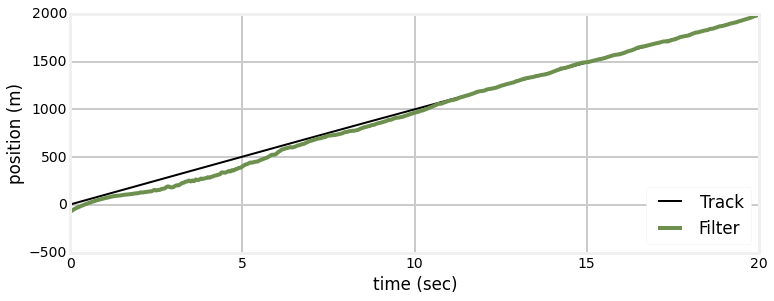

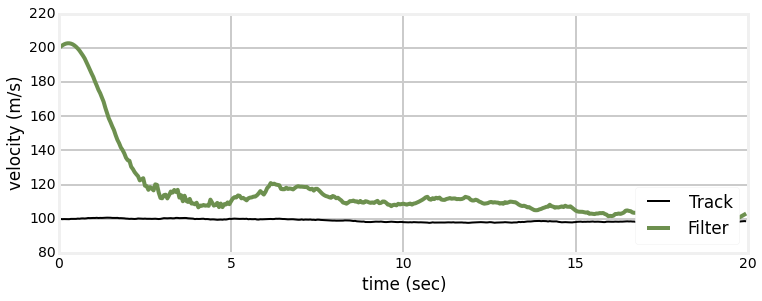

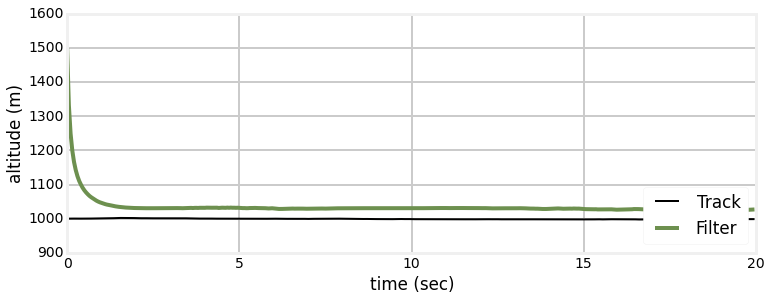

In [16]:
from filterpy.kalman import ExtendedKalmanFilter
from numpy import eye, array, asarray
import book_plots as bp

dt = 0.05
rk = ExtendedKalmanFilter(dim_x=3, dim_z=1)
radar = RadarSim(dt, pos=0., vel=100., alt=1000.)

# make an imperfect starting guess
rk.x = array([radar.pos-100, radar.vel+100, radar.alt+1000])


rk.F = eye(3) + array([[0, 1, 0],
                       [0, 0, 0],
                       [0, 0, 0]])*dt

rk.R = radar.alt * 0.05 # 5% of distance
rk.Q = array([[0, 0, 0],
              [0, 1, 0],
              [0, 0, 1]]) * 0.001
'''
wv = .1**2
wa = .1**2
rk.Q = array([[dt**3 * wv/3, dt**2*wv/2, 0],
              [dt**2*wv/2, dt*wv, 0],
              [0, 0, wa*dt]])'''
rk.P *= 50


xs = []
track = []
for i in range(int(20/dt)):
    z = radar.get_range()
    track.append((radar.pos, radar.vel, radar.alt))
    
    rk.update(array([z]), HJacobian_at, hx)
    xs.append(rk.x)
    rk.predict()


xs = asarray(xs)
track = asarray(track)
time = np.arange(0, len(xs)*dt, dt)

plt.figure()
bp.plot_track(time, track[:, 0])
bp.plot_filter(time, xs[:, 0])
plt.legend(loc=4)
plt.xlabel('time (sec)')
plt.ylabel('position (m)')


plt.figure()
bp.plot_track(time, track[:, 1])
bp.plot_filter(time, xs[:, 1])
plt.legend(loc=4)
plt.xlabel('time (sec)')
plt.ylabel('velocity (m/s)')

plt.figure()
bp.plot_track(time, track[:, 2])
bp.plot_filter(time, xs[:, 2])
plt.ylabel('altitude (m)')
plt.legend(loc=4)
plt.xlabel('time (sec)')
plt.ylim((900, 1600))
plt.show()

## Using SymPy to compute Jacobians

Depending on your experience with derivatives you may have found the computation of the Jacobian above either fairly straightforward, or quite difficult. Even if you found it easy, a slightly more difficult problem easily leads to very difficult computations.

As explained in Appendix A, we can use the SymPy package to compute the Jacobian for us. 

In [17]:
import sympy
sympy.init_printing(use_latex='mathjax')

x_pos, x_vel, x_alt = sympy.symbols('x_pos, x_vel x_alt')

H = sympy.Matrix([sympy.sqrt(x_pos**2 + x_alt**2)])

state = sympy.Matrix([x_pos, x_vel, x_alt])
H.jacobian(state)

⎡       x_pos                    x_alt        ⎤
⎢────────────────────  0  ────────────────────⎥
⎢   _________________        _________________⎥
⎢  ╱      2        2        ╱      2        2 ⎥
⎣╲╱  x_alt  + x_pos       ╲╱  x_alt  + x_pos  ⎦

This result is the same as the result we computed above, and at much less effort on our part!

## Designing Q

**author's note: ignore this, it  to be revised - noise in position and altitude is independent, not dependent**

Now we need to design the process noise matrix $\mathbf{Q}$. From the previous section we have the system equation

$$\dot{\mathbf{x}} = \begin{bmatrix} 0 & 1 & 0 \\ 0& 0& 0 \\ 0&0&0\end{bmatrix}
\begin{bmatrix}x_{pos} \\x_{vel}\\ x_{alt}\end{bmatrix} + \begin{bmatrix}0 \\w_{vel}\\ w_{alt}\end{bmatrix}
$$

where our process noise is

$$w = \begin{bmatrix}0 \\w_{vel}\\ w_{alt}\end{bmatrix}$$

We know from the Kalman filter math chapter that 

$$\mathbf{Q} = E(ww^T)$$

where $E(\bullet)$ is the expected value. We compute the expected value as

$$\mathbf{Q} = \int_0^{dt} \Phi(t)\mathbf{Q}\Phi^T(t) dt$$

Rather than do this by hand, let's use sympy.

In [18]:
import sympy
sympy.init_printing(use_latex='mathjax')
w_vel, w_alt, dt = sympy.symbols('w_vel w_alt \Delta{t}')
w = sympy.Matrix([[0, w_vel, w_alt]]).T
phi = sympy.Matrix([[1, dt, 0], [0, 1, 0], [0,0,1]])

q = w*w.T

sympy.integrate(phi*q*phi.T, (dt, 0, dt))

⎡           3      2                2      2             2            ⎤
⎢  \Delta{t} ⋅w_vel        \Delta{t} ⋅w_vel     \Delta{t} ⋅w_alt⋅w_vel⎥
⎢  ─────────────────       ─────────────────    ──────────────────────⎥
⎢          3                       2                      2           ⎥
⎢                                                                     ⎥
⎢           2      2                                                  ⎥
⎢  \Delta{t} ⋅w_vel                       2                           ⎥
⎢  ─────────────────       \Delta{t}⋅w_vel      \Delta{t}⋅w_alt⋅w_vel ⎥
⎢          2                                                          ⎥
⎢                                                                     ⎥
⎢         2                                                           ⎥
⎢\Delta{t} ⋅w_alt⋅w_vel                                           2   ⎥
⎢──────────────────────  \Delta{t}⋅w_alt⋅w_vel     \Delta{t}⋅w_alt    ⎥
⎣          2                                                    

## Example: A falling Ball

In the **Designing Kalman Filters** chapter I first considered tracking a ball in a vacuum, and then in the atmosphere. The Kalman filter performed very well for vacuum, but diverged from the ball's path in the atmosphere. Let us look at the output; to avoid littering this chapter with code from that chapter I have placed it all in the file `ekf_internal.py'.

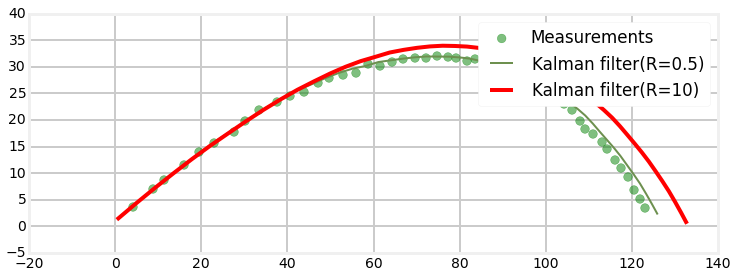

In [19]:
import ekf_internal
ekf_internal.plot_ball()

We can artificially force the Kalman filter to track the ball by making $Q$ large. That would cause the filter to mistrust its prediction, and scale the kalman gain $K$ to strongly favor the measurments. However, this is not a valid approach. If the Kalman filter is correctly predicting the process we should not 'lie' to the filter by telling it there are process errors that do not exist. We may get away with that for some problems, in some conditions, but in general the Kalman filter's performance will be substandard.

Recall from the **Designing Kalman Filters** chapter that the acceleration is

$$a_x = (0.0039 + \frac{0.0058}{1+\exp{[(v-35)/5]}})*v*v_x \\
a_y = (0.0039 + \frac{0.0058}{1+\exp{[(v-35)/5]}})*v*v_y- g
$$

These equations will be very unpleasant to work with while we develop this subject, so for now I will retreat to a simpler one dimensional problem using this simplified equation for acceleration that does not take the nonlinearity of the drag coefficient into account:


$$\ddot{x} = \frac{0.0034ge^{-x/20000}\dot{x}^2}{2\beta} - g$$

Here $\beta$ is the ballistic coefficient, where a high number indicates a low drag.